__CRASHCAL__

CrashCal is an AI-powered solution designed to automate car damage assessment by analyzing vehicle images. It detects whether a car is damaged, identifies the damaged part, estimates the severity of the damage, and predicts the repair cost. This tool aims to streamline the insurance claims and repair estimation process with speed and accuracy.

Step 1: Car Detection

Step 2: Damage Detection

Step 3: Damage Localization (Which Part is Damaged)

Step 4: Damage Severity Estimation

Step 5: Repair Cost Prediction

Step 6: Integration and Frontend Development

![flowchart](flowchart.jpg)

__STEP 1: CAR DETECTION__

1. Importing libraries 

In [1]:
import os
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import UnidentifiedImageError, Image
import warnings
warnings.filterwarnings("ignore")

2. Data Cleaning
   
   a). Iterates through images in specified folders, 

   b). verifies if they are corrupted, 

   c). and removes any corrupted images it finds.

In [2]:
def remove_corrupted_images(data_dir):
    for folder in ['car', 'not_car']:
        folder_path = os.path.join(data_dir, folder)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            try:
                img = Image.open(file_path)
                img.verify()  # Check if image is corrupted
            except (IOError, UnidentifiedImageError):
                print(f"Removing corrupted image: {file_path}")
                os.remove(file_path)

# Call this function on your dataset folder
data_dir = r"E:\car_crash\cars"
remove_corrupted_images(data_dir)

This function attempts to load and preprocess an image, returning it as a normalized array, and skips the image if it’s corrupted.

In [3]:
def load_image_safe(image_path):
    try:
        img = image.load_img(image_path, target_size=(150, 150))
        return image.img_to_array(img) / 255.0
    except UnidentifiedImageError:
        print(f"Warning: Skipping corrupted image {image_path}")
        return None

Generates batches of preprocessed images and their corresponding labels for training a neural network.

In [4]:
from tensorflow.keras.utils import Sequence

class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size, img_size=(150, 150)):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size

    def __len__(self):
        return len(self.file_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_paths = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        labels = []
        
        for i, path in enumerate(batch_paths):
            img = load_image_safe(path)
            if img is not None:
                images.append(img)
                labels.append(batch_labels[i])
        
        return np.array(images), np.array(labels)

3. Data preparation pipeline.

In [5]:
from sklearn.model_selection import train_test_split

# Get image paths and labels
car_paths = [os.path.join(data_dir, 'car', img) for img in os.listdir(os.path.join(data_dir, 'car'))]
not_car_paths = [os.path.join(data_dir, 'not_car', img) for img in os.listdir(os.path.join(data_dir, 'not_car'))]

all_image_paths = car_paths + not_car_paths
labels = [1] * len(car_paths) + [0] * len(not_car_paths)  # 1 for car, 0 for not_car

# Split the data into train and validation sets
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(all_image_paths, labels, test_size=0.2, random_state=42)

# Create generators
train_generator = CustomDataGenerator(train_image_paths, train_labels, batch_size=250)
validation_generator = CustomDataGenerator(val_image_paths, val_labels, batch_size=250)

4. CNN model
   
   a) using three convolutional layers with ReLU activation & passes it through fully connected layers for binary classification with a sigmoid output. 

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

5. Model training 

   a) trains CNN model on training dataset
   
   b) tests the model on validation dataset
   
   c) runs for 5 epochs

In [7]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator)

Epoch 1/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 461s 9s/step - accuracy: 0.7003 - loss: 0.6273 - val_accuracy: 0.9538 - val_loss: 0.2213
Epoch 2/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 452s 9s/step - accuracy: 0.9431 - loss: 0.2275 - val_accuracy: 0.9615 - val_loss: 0.1315
Epoch 3/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 495s 10s/step - accuracy: 0.9543 - loss: 0.1499 - val_accuracy: 0.9476 - val_loss: 0.1707
Epoch 4/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 599s 12s/step - accuracy: 0.9525 - loss: 0.1388 - val_accuracy: 0.9669 - val_loss: 0.1127
Epoch 5/5
47/47 ━━━━━━━━━━━━━━━━━━━━ 442s 9s/step - accuracy: 0.9656 - loss: 0.0980 - val_accuracy: 0.9564 - val_loss: 0.1175


Model evaluation

In [8]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

11/11 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.9538 - loss: 0.1272
Validation Accuracy: 0.96


6. Model saving

In [9]:
# Save the model in HDF5 format
model.save('car_classification_model.h5')

7. Data visualization

   a) plot for training vs validation accuracy and loss 

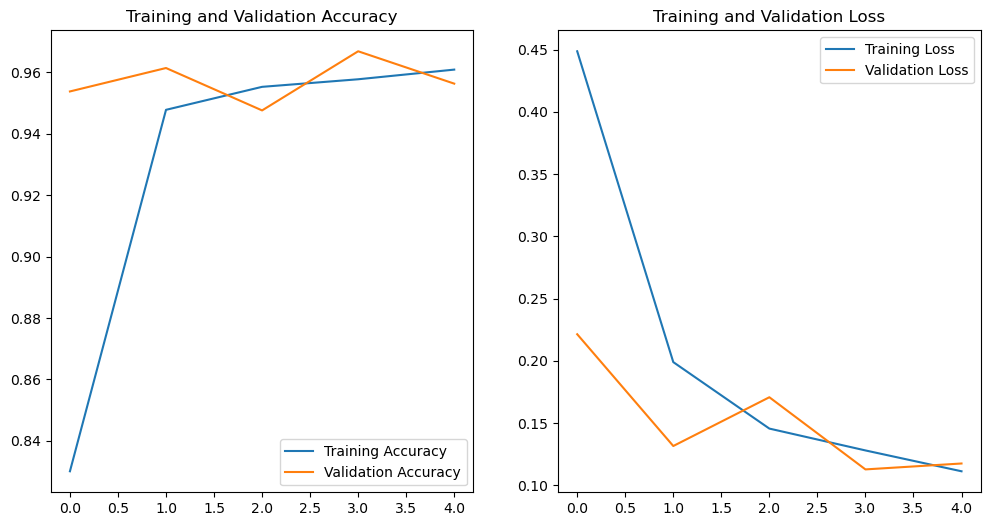

In [10]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(5)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

b) Confusion Matrix 

11/11 ━━━━━━━━━━━━━━━━━━━━ 66s 6s/step


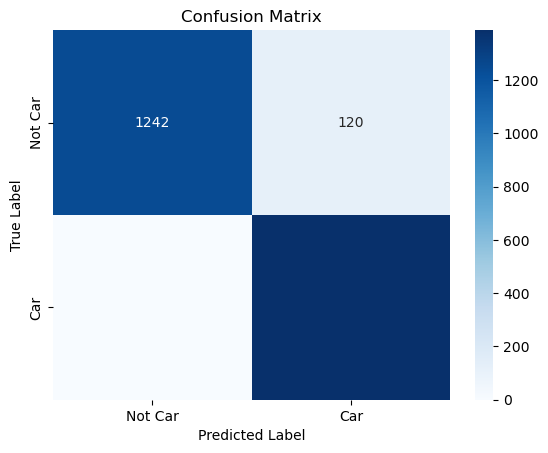

In [11]:
# Evaluate model on validation set
Y_pred = model.predict(validation_generator)
y_pred = (Y_pred > 0.5).astype(int)

cm = confusion_matrix(val_labels[:len(y_pred)], y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Car', 'Car'], yticklabels=['Not Car', 'Car'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

8. Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step


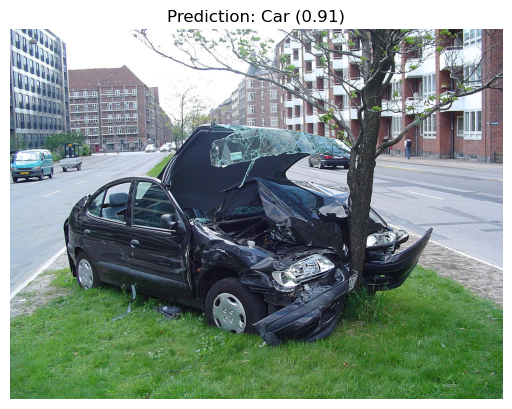

In [12]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

# Function to load and preprocess the image
def load_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))  # Resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Function to visualize prediction
def visualize_prediction(image_path, model):
    img_array = load_image(image_path)
    prediction = model.predict(img_array)[0][0]  # Predict using the trained model
    
    # Assign label based on prediction threshold (0.5)
    label = "Car" if prediction >= 0.5 else "Not Car"
    
    # Load original image for display
    original_image = image.load_img(image_path)
    
    # Plot the image with the predicted label
    plt.imshow(original_image)
    plt.title(f"Prediction: {label} ({prediction:.2f})")
    plt.axis('off')
    plt.show()

# Test with an example image from your dataset
test_image_path = r"E:\car_crash\test\test1.jpg"  # Path to test image
visualize_prediction(test_image_path, model)


In [13]:
def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    if prediction < 0.8:
        print("The image is predicted to be: Not a Car")
    else:
        print("The image is predicted to be: A Car")

# Test with a random image
img_path = r"E:\car_crash\test\test1.jpg"  # Image path
predict_image(model, img_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
The image is predicted to be: A Car


__STEP 2: DAMAGE DETECTION__

1. Importing libaries 

In [14]:
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

2. Loading training & validation dataset 

In [15]:
# Directories
train_dir = r"E:\car_crash\damage\training"
val_dir = r"E:\car_crash\damage\validation"

# Parameters
IMG_SIZE = 128
BATCH_SIZE = 32

3. Data(image) preprocessing 

   a) creates data generators to preprocess images by rescaling pixel values , resizing them to the IMG_SIZE and assigning binary labels for classification.

   b) prepares the data for a binary classification model, handling image loading, resizing, and normalization in batches (BATCH_SIZE).

In [16]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2344 images belonging to 2 classes.
Found 460 images belonging to 2 classes.


4. CNN model
   
   a) using three convolutional layers with ReLU activation & passes it through fully connected layers for binary classification with a sigmoid output. 

In [17]:
# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

5. Model training 

   a) trains CNN model on training dataset
   
   b) tests the model on validation dataset
   
   c) runs for 10 epochs

In [18]:
history = model.fit(
    train_generator,validation_data=val_generator,epochs=10  # Adjust based on performance
)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6019 - loss: 0.7088 - val_accuracy: 0.6935 - val_loss: 0.5948
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 655ms/step - accuracy: 0.7511 - loss: 0.5204 - val_accuracy: 0.7457 - val_loss: 0.5222
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 638ms/step - accuracy: 0.8025 - loss: 0.4336 - val_accuracy: 0.7217 - val_loss: 0.5509
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 49s 641ms/step - accuracy: 0.8280 - loss: 0.3893 - val_accuracy: 0.7543 - val_loss: 0.5226
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 49s 640ms/step - accuracy: 0.8635 - loss: 0.3150 - val_accuracy: 0.7783 - val_loss: 0.4642
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 50s 658ms/step - accuracy: 0.8953 - loss: 0.2630 - val_accuracy: 0.7587 - val_loss: 0.5420
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 49s 641ms/step - accuracy: 0.9360 - loss: 0.1628 - val_accuracy: 0.8196 - val_loss: 0.4442
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 51s 657ms/step - accuracy: 0.9742 - loss: 0.0951 - val_accurac

6. Model evaluation

In [19]:
# Evaluate on validation data
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc:.2f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 300ms/step - accuracy: 0.7618 - loss: 0.7564
Validation Accuracy: 0.77


7. Data visualization

   a) plot for training vs validation accuracy and loss 

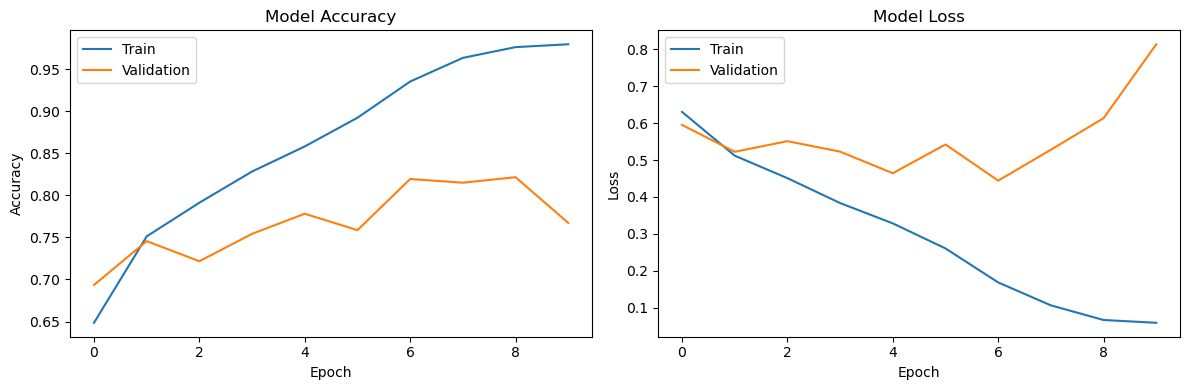

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

b) Predicted vs Actual Results on Sample Validation Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


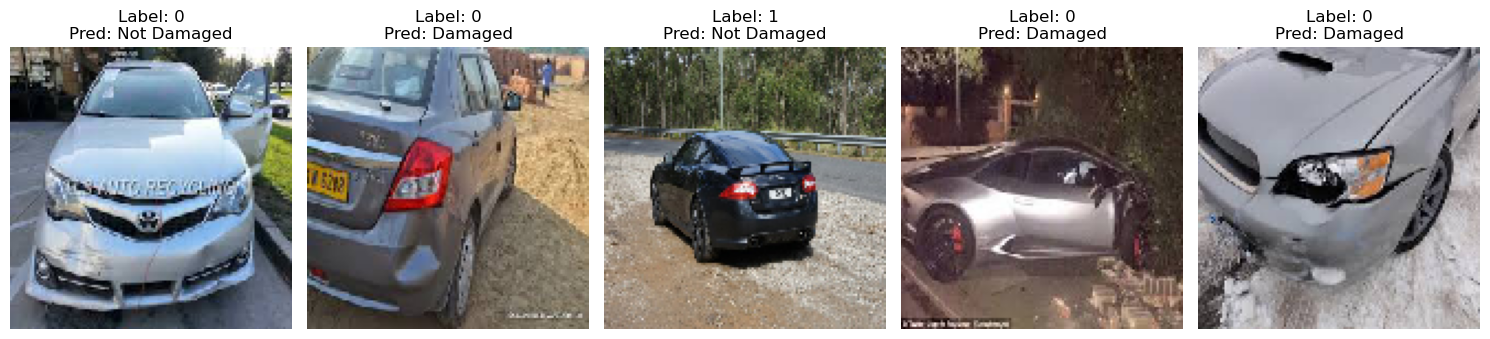

In [21]:
def visualize_predictions(generator, num_images=5):
    # Get a batch of images and labels
    images, labels = next(generator)

    # Generate predictions
    predictions = model.predict(images)

    # Plot images with predictions
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        # Show label and prediction
        plt.title(f"Label: {int(labels[i])}\nPred: {'Not Damaged' if predictions[i] > 0.4 else 'Damaged'}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on validation data
visualize_predictions(val_generator)

c) Confusion matrix 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


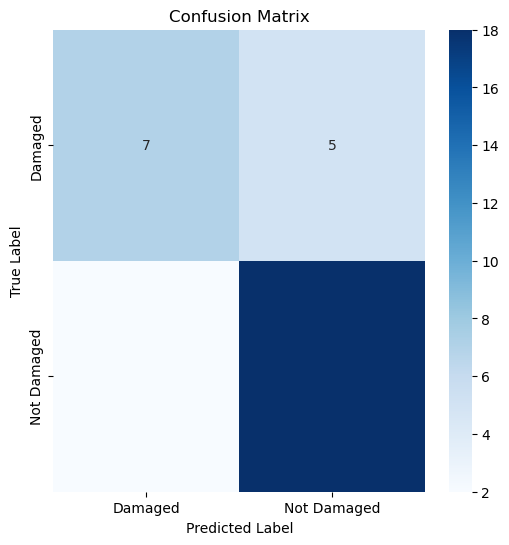

In [22]:
# Generate predictions for the entire validation set
val_images, val_labels = next(val_generator)
predictions = (model.predict(val_images) > 0.85).astype("int32")

# Create a confusion matrix
cm = confusion_matrix(val_labels, predictions)

# Visualize the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Damaged', 'Not Damaged'], yticklabels=['Damaged', 'Not Damaged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

8. Model saving 

In [23]:
model.save('damage_detection_model.h5')

9. Model loading 

In [24]:
# Load the trained model
model = load_model('damage_detection_model.h5')

10. Prediction

In [25]:
# Function to preprocess and predict on a new image
def predict_image(image_path):
    # Load the image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to model input size
    img = img / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict
    prediction = model.predict(img)
    
    # Convert prediction to human-readable form
    if prediction[0] > 0.85:
        print("Prediction: The car is not damaged.")
    else:
        print("Prediction: The car is damaged.")

# Predict on a random image
image_path = r"E:\car_crash\test\test2.jpg"
predict_image(image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Prediction: The car is damaged.


__STEP 3: DAMAGE LOCAlIZATION__

1. Importing Libraries

In [26]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

2. Loading training & validation dataset 

In [27]:
img_width, img_height = 224, 224
batch_size = 32

train_data_dir = r"E:\car_crash\position\training"
validation_data_dir = r"E:\car_crash\position\validation"

3. Data(image) preprocessing 

   a) creates data generators to preprocess images by rescaling pixel values , resizing them to the IMG_SIZE and assigning binary labels for classification.

   b) prepares the data for a binary classification model, handling image loading, resizing, and normalization in batches (BATCH_SIZE).

In [28]:
train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'  # Since we have 3 classes: front, side, back
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


4. CNN model
   
   a) using three convolutional layers with ReLU activation & passes it through fully connected layers for binary classification with a sigmoid output. 

In [29]:
model = Sequential()
# Add layers
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 classes (front, side, back)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,397,635 (169.36 MB)

 Trainable params: 44,397,635 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

5. Model training 

   a) trains CNN model on training dataset
   
   b) tests the model on validation dataset
   
   c) runs for 10 epochs

In [30]:
history = model.fit(train_generator,epochs=10,validation_data=validation_generator)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 83s 2s/step - accuracy: 0.3618 - loss: 4.7750 - val_accuracy: 0.2982 - val_loss: 1.1067
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.4281 - loss: 1.0745 - val_accuracy: 0.4327 - val_loss: 1.0598
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.4764 - loss: 1.0177 - val_accuracy: 0.4269 - val_loss: 1.0555
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.5153 - loss: 0.9591 - val_accuracy: 0.4678 - val_loss: 1.1057
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.6721 - loss: 0.7233 - val_accuracy: 0.4094 - val_loss: 1.2190
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - accuracy: 0.8383 - loss: 0.4444 - val_accuracy: 0.4620 - val_loss: 1.5947
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.9391 - loss: 0.2141 - val_accuracy: 0.4620 - val_loss: 2.0346
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.9775 - loss: 0.0720 - val_accuracy: 0.5029 - val_loss:

6. Model evaluation

In [31]:
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation accuracy: {accuracy * 100:.2f}%")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step - accuracy: 0.5152 - loss: 2.7921
Validation accuracy: 48.54%


7. Model saving

In [32]:
# Save the trained model
model.save('location_detection_model.h5')

8. Model loading

In [33]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('location_detection_model.h5')

9. Prediction

In [35]:
import warnings 
warnings.filterwarnings("ignore")

# Image dimensions
img_width, img_height = 224, 224

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale the image
    return img_array

# Load the saved model
model = load_model("location_detection_model.h5")

# Predict damage location
img_path = r"E:\car_crash\test\test1.jpg"  # Replace with your image path
img_array = load_and_preprocess_image(img_path)

# Get prediction
prediction = model.predict(img_array)

# Decode prediction
class_labels = ['front', 'side', 'back']
predicted_class = np.argmax(prediction, axis=1)[0]  # Get the index of the highest probability
predicted_label = class_labels[predicted_class]

print(f"The predicted damage location is: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
The predicted damage location is: front


10. Visualization 

a) Training and Validation Accuracy and Loss Visualization

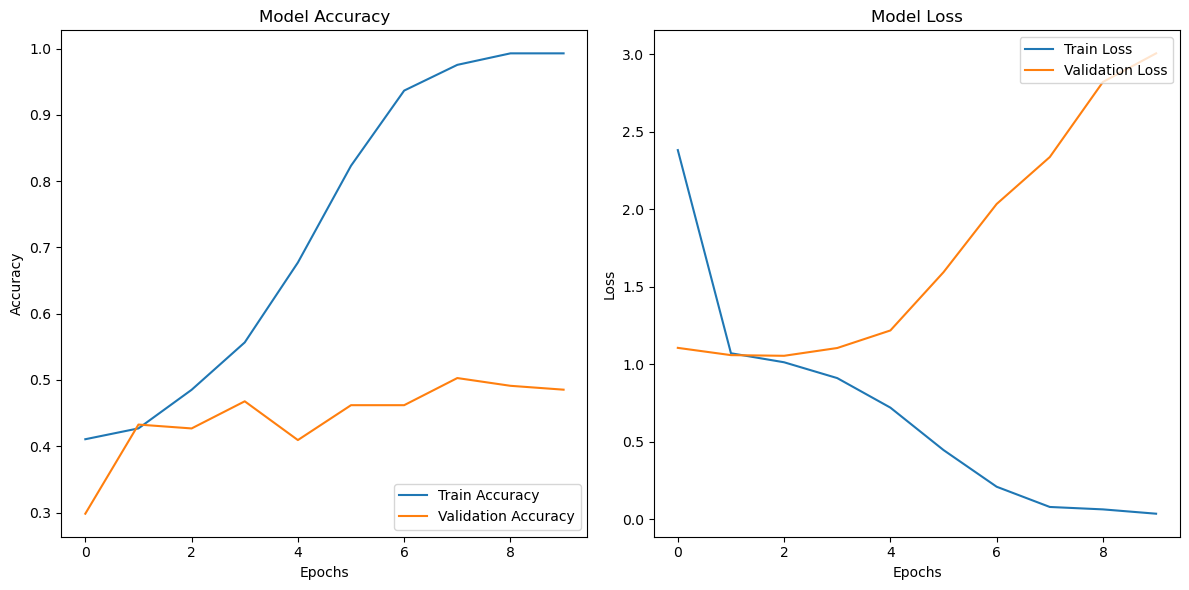

In [36]:
import matplotlib.pyplot as plt

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

b) Confusion Matrix for Predictions on the Validation Set

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 438ms/step


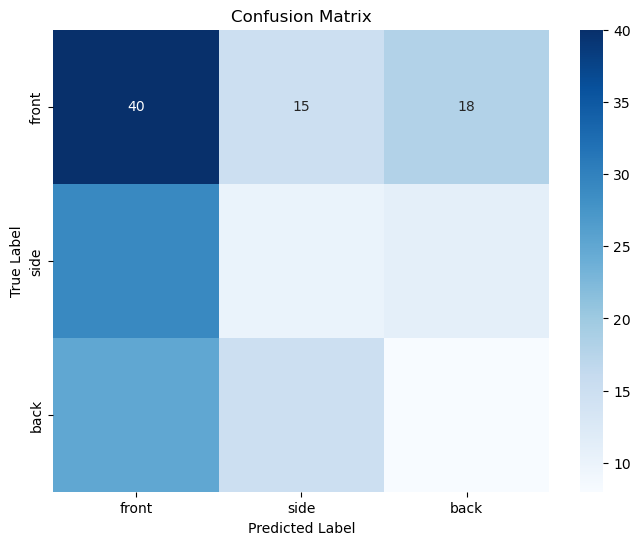

In [37]:
import warnings 
warnings.filterwarnings("ignore")

# Generate predictions on validation data
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
class_names = ['front', 'side', 'back']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

c) Visualization of Test Image and Predicted Class

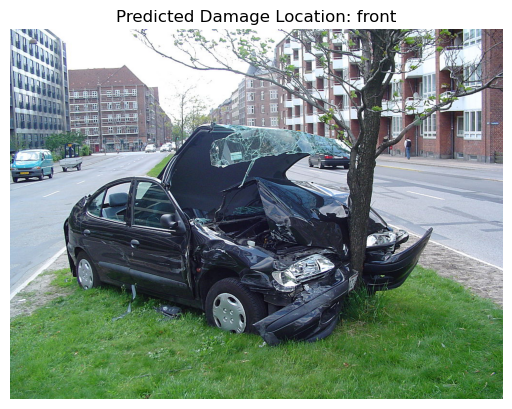

In [38]:
# Display the image with prediction
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted Damage Location: {predicted_label}")
plt.show()

__STEP 4: SEVERITY CHECK__

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Set up the paths
train_dir = r"E:\car_crash\level\training"  # Replace with your training directory path
val_dir = r"E:\car_crash\level\validation"   # Replace with your validation directory path

In [2]:
# Define parameters
img_height, img_width = 150, 150  # Adjust based on your needs
batch_size = 32
epochs = 10  # You can adjust this based on your dataset

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 979 images belonging to 3 classes.
Found 171 images belonging to 3 classes.


In [4]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3 output classes
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Taranjot\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)

Epoch 1/10


C:\Users\Taranjot\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


30/30 ━━━━━━━━━━━━━━━━━━━━ 35s 892ms/step - accuracy: 0.3598 - loss: 1.2328 - val_accuracy: 0.3750 - val_loss: 1.0730
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3125 - loss: 1.0855 - val_accuracy: 0.7273 - val_loss: 0.9228
Epoch 3/10


C:\Users\Taranjot\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 478ms/step - accuracy: 0.4132 - loss: 1.0675 - val_accuracy: 0.4000 - val_loss: 1.1555
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3438 - loss: 1.1057 - val_accuracy: 0.3636 - val_loss: 1.0557
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 476ms/step - accuracy: 0.4457 - loss: 1.0564 - val_accuracy: 0.4500 - val_loss: 1.1764
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.1622 - val_accuracy: 0.3636 - val_loss: 1.1237
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step - accuracy: 0.4643 - loss: 1.0441 - val_accuracy: 0.4187 - val_loss: 1.0316
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2500 - loss: 1.1045 - val_accuracy: 0.6364 - val_loss: 0.9621
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 477ms/step - accuracy: 0.4961 - loss: 1.0033 - val_accuracy: 0.4875 - val_loss: 0.9713
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4375 - loss: 1.0448 - val_accuracy: 0.4545 - val_los

In [6]:
# Evaluate the model
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.4577 - loss: 0.9760 
Validation Loss: 0.9799284338951111, Validation Accuracy: 0.4736842215061188


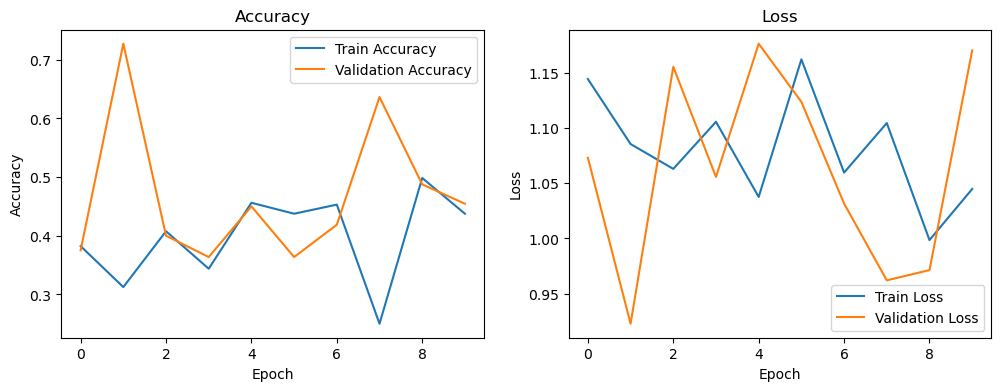

In [7]:
# Plot training & validation accuracy and loss
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

plot_history(history)

In [9]:
# Save the entire model to a file
model.save('severity_model.h5')

In [10]:
# Define category names corresponding to the class indices
category_names = ['minor', 'moderate', 'severe']  # Adjust this based on your folder names

# Function to predict category of a new image
def predict_image(img_path):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_category = category_names[predicted_class_index]
    
    return predicted_category

# Example prediction (replace with an actual image path)
new_image_path = r"E:\car_crash\test\test3.jpg"  # Replace with your image path
predicted_category = predict_image(new_image_path)
print(f'Predicted Category: {predicted_category}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted Category: severe


__PIPLELINE__

In [12]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

# Load all models
car_detection_model = load_model('car_classification_model.h5')  # Step 1 model
damage_detection_model = load_model('damage_detection_model.h5')  # Step 2 model
location_detection_model = load_model('location_detection_model.h5')  # Step 3 model
severity_model = load_model('severity_model.h5')  # CNN model for severity prediction

# Class labels for predictions
car_labels = ['not_car', 'car']
damage_labels = ['not_damaged', 'damaged']
location_labels = ['front', 'side', 'back']
severity_labels = ['minor', 'moderate', 'severe']  # Adjust as per your dataset

# Define thresholds for binary models
car_threshold = 0.5
damage_threshold = 0.5

# Function to preprocess images
def load_and_preprocess_image(img_path, img_width, img_height, flatten=False):
    # Load and resize the image
    img = image.load_img(img_path, target_size=(img_width, img_height))
    img_array = image.img_to_array(img) / 255.0  # Normalize

    # Expand dimensions to match model input (batch size, width, height, channels)
    img_array = np.expand_dims(img_array, axis=0)

    # Flatten if the model expects a flat input
    if flatten:
        img_array = img_array.reshape(1, -1)

    return img_array

# Complete prediction pipeline
def damage_detection_pipeline(img_path):
    print("Starting prediction pipeline...\n")
    
    # Preprocessing for car detection
    car_input_shape = car_detection_model.input_shape
    img_width, img_height = car_input_shape[1], car_input_shape[2]
    img_array = load_and_preprocess_image(img_path, img_width, img_height)

    # Step 1: Car Detection
    car_prediction = car_detection_model.predict(img_array)
    car_predicted_confidence = car_prediction[0][0]  # Binary prediction confidence

    if car_predicted_confidence >= car_threshold:
        print(f"Car Detection: The image contains a car with confidence: {car_predicted_confidence:.2f}")

        # Preprocessing for damage detection
        damage_input_shape = damage_detection_model.input_shape
        img_width, img_height = damage_input_shape[1], damage_input_shape[2]
        flatten_damage_input = len(damage_input_shape) == 2
        img_array = load_and_preprocess_image(img_path, img_width, img_height, flatten=flatten_damage_input)

        # Step 2: Damage Detection
        damage_prediction = damage_detection_model.predict(img_array)
        damage_predicted_confidence = damage_prediction[0][0]  # Binary prediction confidence

        if damage_predicted_confidence >= damage_threshold:
            print(f"Damage Detection: The car is damaged with confidence: {damage_predicted_confidence:.2f}")

            # Preprocessing for location detection
            location_input_shape = location_detection_model.input_shape
            img_width, img_height = location_input_shape[1], location_input_shape[2]
            flatten_location_input = len(location_input_shape) == 2
            img_array = load_and_preprocess_image(img_path, img_width, img_height, flatten=flatten_location_input)

            # Step 3: Location Detection
            location_prediction = location_detection_model.predict(img_array)
            location_predicted_class = np.argmax(location_prediction, axis=1)[0]
            location_confidence = location_prediction[0][location_predicted_class]

            location_result = f"Damage is at the {location_labels[location_predicted_class]} with confidence: {location_confidence:.2f}"
            print(location_result)

            # Preprocessing for severity detection (same image)
            severity_input_shape = severity_model.input_shape
            img_width, img_height = severity_input_shape[1], severity_input_shape[2]
            img_array = load_and_preprocess_image(img_path, img_width, img_height)

            # Step 4: Severity Detection
            severity_prediction = severity_model.predict(img_array)
            severity_class = np.argmax(severity_prediction, axis=1)[0]
            severity_confidence = severity_prediction[0][severity_class]

            severity_result = f"Damage severity is {severity_labels[severity_class]} with confidence: {severity_confidence:.2f}"
            print(severity_result)

        else:
            print(f"The car is not damaged with confidence: {1 - damage_predicted_confidence:.2f}")
    else:
        print(f"The image does not contain a car with confidence: {1 - car_predicted_confidence:.2f}")

# Example usage
img_path = r"E:\car_crash\test\test2.jpg"  # Replace with the actual image path
damage_detection_pipeline(img_path)


Starting prediction pipeline...



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Car Detection: The image contains a car with confidence: 0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
Damage Detection: The car is damaged with confidence: 0.59
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Damage is at the side with confidence: 1.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Damage severity is severe with confidence: 0.60
